In [1]:
import h5py
import os
import re
import numpy as np
from math import sqrt, log10

# load data

In [2]:
data_root = "D:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results"

def read_matlab_v73_file(label, batch, frame):
    file_path = os.path.join(data_root, f"Label_{label}/Batch_{batch}/Frame_{frame}/MTD_result.mat")
    with h5py.File(file_path, 'r') as f:
        var_names = list(f.keys())
        data = {}

        for var_name in var_names:
            # HDF5 中的数据是按列优先存储的，而 NumPy 是按行优先，因此需要转置
            if isinstance(f[var_name], h5py.Dataset):
                data[var_name] = np.array(f[var_name]).T

        return data

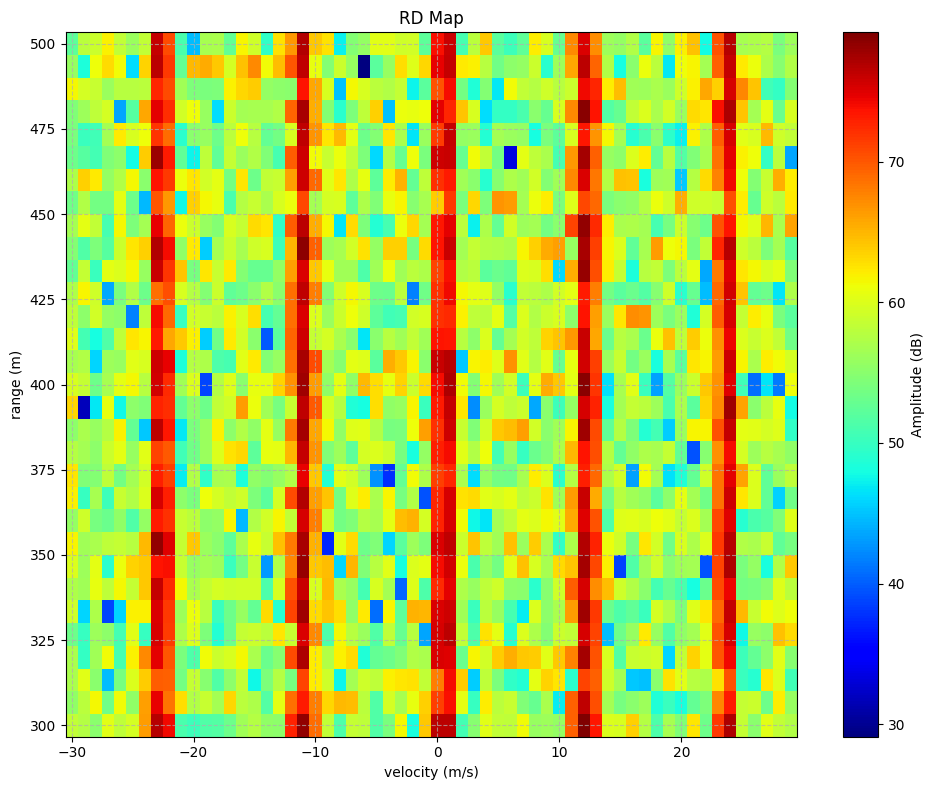

In [8]:
from matplotlib import pyplot as plt


mtd_result = np.load(os.path.join(data_root, "../python处理结果/Batch_1333_Label_2/Frame_10/MTD_Result.npy"))
mtd_result = np.abs(mtd_result)
mtd_result = 20 * np.log10(mtd_result)
mtd_result = mtd_result[:, 150:210]
plt.figure(figsize=(10, 8))

X, Y = np.meshgrid(np.arange(-30, 30, 1), np.linspace(300, 500, mtd_result.shape[0]))
plt.pcolormesh(X, Y, mtd_result, shading='auto', cmap='jet')
plt.colorbar(label='Amplitude (dB)')
plt.xlabel('velocity (m/s)')
plt.ylabel('range (m)')
plt.title('RD Map')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# visualize

In [3]:
def check_path(path):
    path = os.path.dirname(path)
    if not os.path.exists(path):
        os.makedirs(path)


def split_scientific_str(num, precision=10):
    """使用字符串格式化将一个数分成科学计数法的尾数和指数两部分"""
    scientific_str = f"{num:.{precision}e}"
    match = re.match(r'([+-]?\d+\.\d+)e([+-]?\d+)', scientific_str)
    if match:
        mantissa = float(match.group(1))
        exponent = int(match.group(2))
        return mantissa, exponent
    return num, 0


def visualize_rd_matrix(data, save_path=None, eps=1e-6, verbose=False):
    """可视化 RD 矩阵"""
    rd_matrix = data['rd_matrix']
    value = np.zeros_like(rd_matrix, dtype=np.float64)
    for i in range(len(rd_matrix)):
        for j in range(len(rd_matrix[i])):
            real = rd_matrix[i][j][0]
            real_mantissa, real_exponent = split_scientific_str(real)
            imag = rd_matrix[i][j][1]
            imag_mantissa, imag_exponent = split_scientific_str(imag)
            if real_exponent > imag_exponent:
                real_mantissa *= 10 ** (real_exponent - imag_exponent)
                value[i][j] = 10 * (log10(real_mantissa ** 2 + imag_mantissa ** 2 + eps) +  2 * imag_exponent)
            elif real_exponent < imag_exponent:
                imag_mantissa *= 10 ** (imag_exponent - real_exponent)
                value[i][j] = 20 * (log10(sqrt(real_mantissa ** 2 + imag_mantissa ** 2 + eps)) + real_exponent)
            else:
                value[i][j] = 20 * (log10(sqrt(real_mantissa ** 2 + imag_mantissa ** 2 + eps)) + real_exponent)

    range_axis = data['range_axis']
    velocity_axis = data['velocity_axis']

    velocity_index = np.where(np.reshape(velocity_axis, -1) == 0)[0][0]
    value[:, velocity_index-4:velocity_index+3] = 0
    value[value < np.percentile(value, 5)] = 0

    if verbose:
        print(f"RD矩阵形状: {rd_matrix.shape}")

    plt.figure(figsize=(10, 8))

    X, Y = np.meshgrid(velocity_axis, range_axis)
    plt.pcolormesh(X, Y, value, shading='auto', cmap='jet')
    plt.xlim(-30, 30)
    plt.colorbar(label='Amplitude (dB)')
    plt.xlabel('velocity (m/s)')
    plt.ylabel('range (m)')
    plt.title('RD Map')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    if save_path:
        check_path(save_path)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

RD矩阵形状: (31, 360)


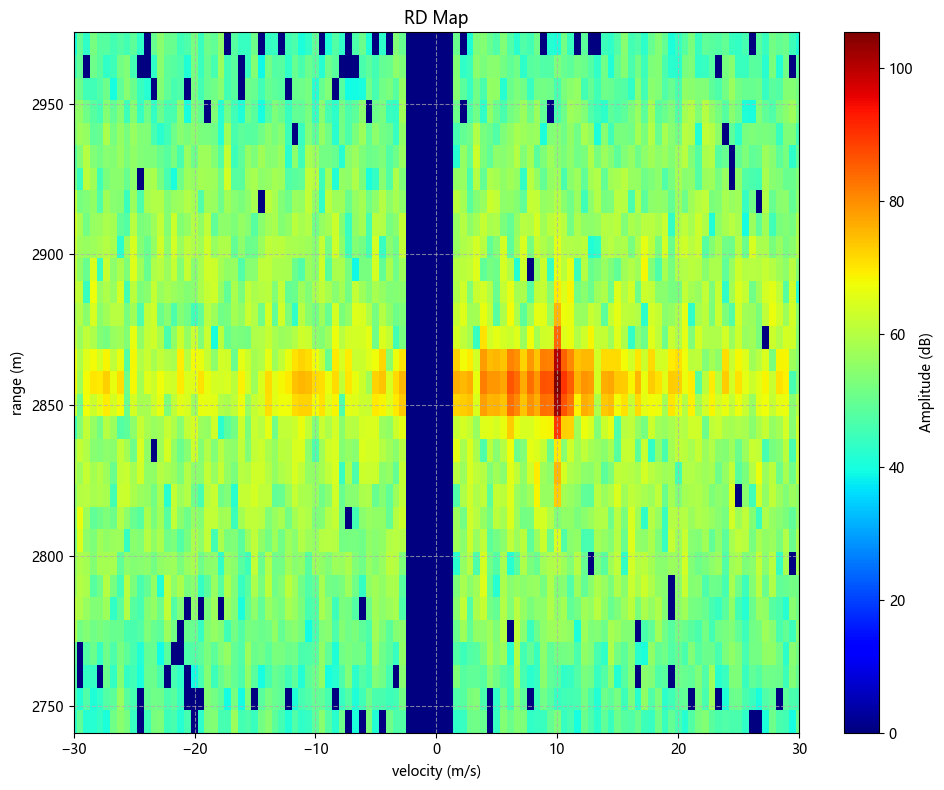

In [4]:
label = 2
batch = 1333
frame = 10

data = read_matlab_v73_file(label, batch, frame)
visualize_rd_matrix(data, verbose=True)

# 批量处理

In [3]:
import glob

In [4]:
label_dirs = glob.glob(f"{data_root}/Label_*")
image_sizes = []
for label_dir in label_dirs:
    label = int(label_dir.split("_")[-1])
    batch_dirs = glob.glob(f"{label_dir}/Batch_*")
    for batch_dir in batch_dirs:
        batch = int(batch_dir.split("_")[-1])
        frame_dirs = glob.glob(f"{batch_dir}/Frame_*")
        for frame_dir in frame_dirs:
            frame = int(frame_dir.split("_")[-1])
            data = read_matlab_v73_file(label, batch, frame)
            rd_matrix = data['rd_matrix']
            velocity_axis = data['velocity_axis']
            velocity_mask = np.reshape(np.abs(velocity_axis) < 56, -1)
            rd_matrix = rd_matrix[:, velocity_mask]
            image_size = rd_matrix.shape
            if image_size not in image_sizes:
                image_sizes.append(image_size)
print(image_sizes)

[(31, 53), (31, 65), (31, 201), (31, 217), (31, 503), (31, 545), (31, 319), (31, 345), (31, 47), (31, 141), (31, 127)]


In [12]:
import plotly.graph_objects as go

frame_nums = []
label_dirs = glob.glob(f"{data_root}/Label_*")
for label_dir in label_dirs:
    batch_dirs = glob.glob(f"{label_dir}/Batch_*")
    for batch_dir in batch_dirs:
        frame_dirs = glob.glob(f"{batch_dir}/Frame_*")
        frame_nums.append(len(frame_dirs))

fig = go.Figure(data=[go.Histogram(x=frame_nums, histnorm='probability', nbinsx=10)])
fig.update_layout(
    title_text="Frame Number Distribution",
    xaxis_title_text="Frame Number",
    yaxis_title_text="Probability",
    bargap=0.2,
    bargroupgap=0.1
)
fig.show()

In [15]:
count = 0
for frame_num in frame_nums:
    if frame_num > 64:
        count += 1
print(count / len(frame_nums))

0.48838709677419356


In [14]:
data_root = "E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results"
label_dirs = glob.glob(f"{data_root}/Label_*")
max_velocity = 0
for label_dir in label_dirs:
    batch_dirs = glob.glob(f"{label_dir}/Batch_*")
    for batch_dir in batch_dirs:
        frame_dirs = glob.glob(f"{batch_dir}/Frame_*")
        for frame_dir in frame_dirs:
            data = read_matlab_v73_file(label, batch, frame)
            velocity = abs(data["velocity"][0][0])
            if velocity > 30:
                print(frame_dir)
            max_velocity = max(max_velocity, velocity)
print(max_velocity)

E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_53
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_54
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_55
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_56
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_57
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_58
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_59
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_111\Frame_60
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_121\Frame_57
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_121\Frame_58
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_166\Frame_60
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_166\Frame_61
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_208\Frame_1
E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results\Label_1\Batch_208\Fr

In [11]:
label = 1
batch = 1
frame = 1
file_path = f"E:/DataSets/挑战杯_揭榜挂帅_CQ-08赛题_数据集/MTD_Results/Label_{label}/Batch_{batch}/Frame_{frame}/MTD_result.mat"
with h5py.File(file_path, 'r') as f:
    var_names = list(f.keys())
    data = {}

    for var_name in var_names:
        # HDF5 中的数据是按列优先存储的，而 NumPy 是按行优先，因此需要转置
        if isinstance(f[var_name], h5py.Dataset):
            data[var_name] = np.array(f[var_name]).T

In [14]:
rd_matrix = data["rd_matrix"]
value = np.zeros_like(rd_matrix, dtype=np.float64)
eps = 1e-10
for i in range(len(rd_matrix)):
    for j in range(len(rd_matrix[i])):
        real = rd_matrix[i][j][0]
        real_mantissa, real_exponent = split_scientific_str(real)
        imag = rd_matrix[i][j][1]
        imag_mantissa, imag_exponent = split_scientific_str(imag)
        if real_exponent > imag_exponent:
            real_mantissa *= 10 ** (real_exponent - imag_exponent)
            value[i][j] = 10 * (log10(real_mantissa ** 2 + imag_mantissa ** 2 + eps) +  2 * imag_exponent)
        elif real_exponent < imag_exponent:
            imag_mantissa *= 10 ** (imag_exponent - real_exponent)
            value[i][j] = 20 * (log10(sqrt(real_mantissa ** 2 + imag_mantissa ** 2 + eps)) + real_exponent)
        else:
            value[i][j] = 20 * (log10(sqrt(real_mantissa ** 2 + imag_mantissa ** 2 + eps)) + real_exponent)
velocity = data["velocity_axis"]
range_axis = data["range_axis"]

# 生成合并特征后的航迹数据集

In [7]:
from tqdm import tqdm


# 查找所有点迹文件
point_track_files = glob.glob(os.path.join(data_root, "../点迹", "PointTracks_*.txt"))
print(f"找到 {len(point_track_files)} 个点迹文件。")

# 遍历点迹文件，寻找对应的航迹文件并合并
max_seq_len = 0
for pt_file in tqdm(point_track_files, desc="处理原始数据"):
    seq_len = int(re.match(r".*PointTracks_(\d+)_(\d+)_(\d+).txt", pt_file).group(3))
    max_seq_len = max(max_seq_len, seq_len)
print(max_seq_len)

找到 1550 个点迹文件。


处理原始数据: 100%|██████████| 1550/1550 [00:00<00:00, 333838.51it/s]

29
